## <center> Обработка данных </center>

### Импорт библиотек

In [1]:
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.contingency_tables import mcnemar

### Загрузка данных

In [47]:
data = pd.read_csv('data/ds_salaries.csv')
data_salary = data.copy()

display(data_salary.tail(5))

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M
606,606,2022,MI,FT,AI Scientist,200000,USD,200000,IN,100,US,L


### Описание столбцов:

- **work_year** - год, в котором была выплачена зарплата; 

- **experience_level** - опты работы на этой должности:
    + EN - Entrylevel/Junior;
    + MI - Mid-level/Intermediate;
    + SE - Senior-level/Expert;
    + EX - Executive-level/Director.

- **employment_type** - тип трудоустройства для этой роли:
    + PT - неполный рабочий день;
    + FT - полный рабочий день;
    + CT - контракт;
    + FL - фриланс.
    
- **job_title** - роль, в которой соискатель работал в течение года;

- **salary** - общая выплаченная валовая сумма заработной платы;

- **salary_currency** - валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;

- **salary_in_usd** - зарплата в долларах США;

- **employee_residence** - основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;

- **remote_ratio** - общий объём работы, выполняемой удалённо:
    + 0 - удалённой работы нет (менее 20%);
    + 50 - частично удалённая работа;
    + 100 - полностью удалённая работа (более 80%).
    
- **company_location** - страна главного офиса работодателя или филиала по кантракту в виде кода страны ISO 3166;
- **company_size** - среднее количество людей, работавших в компании в течение года:
    + S - менее 50 сотрудников (небольшая компания);
    + M - от 50 до 250 сотрудников (средняя компания);
    + L - более 250 сотрудников (крупная компания).

In [48]:
display(data_salary.info())
print('Количество строк в дата-сете:', data_salary.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


None

Количество строк в дата-сете: 607


### Проверка на наличие пропусков

Из представленного выше описания типов столбцов, *в приницпе*, видно, что **пропусков** в представленных данных нет, но кто мы такие, чтобы *верить на слово*? Поэтому прибегнем в фактической проверке данных на наличие **пропусков**.

In [49]:
cols_null_percent = data_salary.isnull().mean() * 100
cols_with_null = cols_null_percent.sort_values(ascending = False)
display(round(cols_with_null, 2))

Unnamed: 0            0.0
work_year             0.0
experience_level      0.0
employment_type       0.0
job_title             0.0
salary                0.0
salary_currency       0.0
salary_in_usd         0.0
employee_residence    0.0
remote_ratio          0.0
company_location      0.0
company_size          0.0
dtype: float64

Так и есть, в наших данных действительно **нет пропусков**.

### Проверка на наличие дубликатов

Другим немаловажным фактором является наличие **дубликатов**. Их наличие также необходимо исключить из представленных данных.

In [55]:
dupl_columns = list(data_salary.columns)

mask = data_salary.duplicated(subset = dupl_columns)
data_salary_duplicated = data_salary[mask]
print(f'Число нйденных дубликатов: {data_salary_duplicated.shape[0]}')

Число нйденных дубликатов: 0


А вот **полных дубликатов** в представленном дата-сете аж целых 42 строки. От них необходимо **избавиться**.

In [6]:
data_salary = data_salary.drop_duplicates(subset = dupl_columns)
print(f'Результирующее число записей: {data_salary.shape[0]}')

Результирующее число записей: 607


### Удаление неинформативных признаков

**Неинформативные признаки** - это лишние данные в дата-сете, которые не несут практической пользы, занимают место в *таблице* и не принимают участия в исследованиях.

По моему *скромному* мнению к таким признакам можно отнести колонки: **Unnamed : 0** так как он дублирует индексы таблицы, а также колонки **salary** и **salary_currency**.Колонки ***заработной платы*** и ***валюты выплачиваемой зарплаты*** не имеют практического смысла, так как они *выражены в разных единицах измерениях*. Так же у нас есть признак ***salary_in_usd*** для абсолютного выражения заработных плат в *единой системе измерения*.

In [7]:
data_salary.drop(['Unnamed: 0', 'salary', 'salary_currency'], axis = 1, inplace = True)

display(data_salary.head(5))

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


Оставшиеся признаки, на мой взгляд, вполне нам пригодятся для последующей аналитики данных.

### Заданный по условию аттестации уровень значимости $\alpha$

In [8]:
alpha = 0.05

## <center> Задание №1: *наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?*

Первым делом попробуем решить данную задачу **"в лоб"**, выполнив визуальную оценку представленных данных.

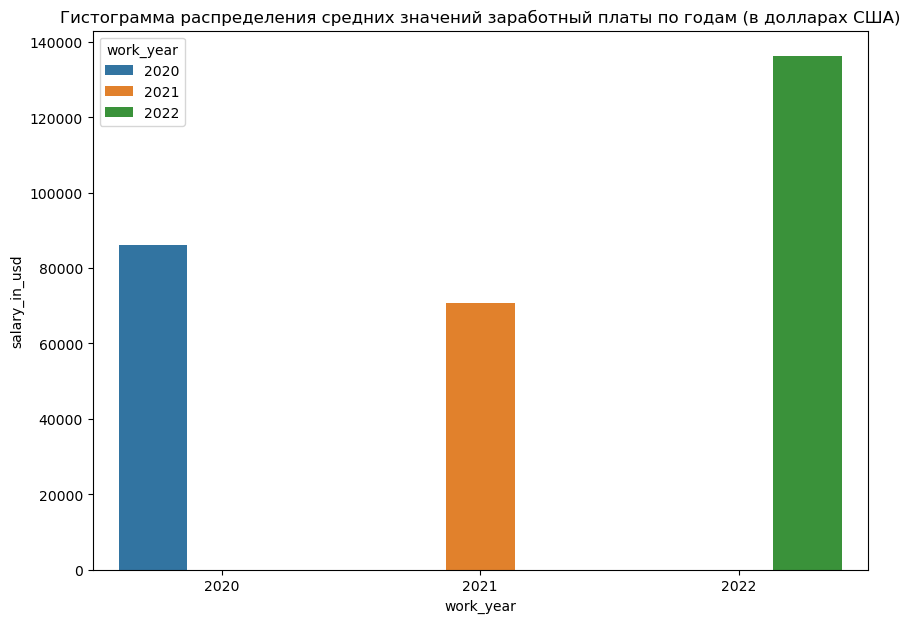

In [9]:
fig = plt.figure(figsize = (10, 7))

barplot = sns.barplot(
    data = data_salary[data_salary['job_title'] == 'Data Scientist'],
    x = 'work_year',
    y = 'salary_in_usd',
    hue = 'work_year',
    errorbar = None
)
barplot.set_title('Гистограмма распределения средних значений заработный платы по годам (в долларах США)');

Визуальная оценка представленной выше гистограммы **не даёт** нам возможности заявить, что у специалистов Data Scientist действительно наблюдается ежегодный рост заработной платы. Но так ли это на самом деле нам скажут **статистические тесты**.

Для начала сравним средние значения для всех трёх групп, чтобы выяснить - есть ли смысл проверять данные дальше. *Вдруг средние значения заработных плат за три года на самом деле одинаковы*. Для этой проверки воспользуемся **однофакторным дисперсионным анализом ANOVA**, так как **врядли одни и те же** люди ищёт работу на протяжении всех **трёх лет**.

Однако у данного метода есть ряд **ограничений**:
* тест можно выполнять только на группах с равной дисперсией;
* тест можно выполнять только, если данные во всех выборках распределены нормально.

Из теоритического курса мы помним, что зарплаты **редко когда имеют нормальное распределение**, поэтому первым делом выполним проверку именно по этому критерию. 

### Проверка данных на нормальность распределения

Для нашего удобства создадим отдельные переменные, в которых будут храниться данные о заработных платах по годам

In [10]:
data_salary_2020 = data_salary[(data_salary['work_year'] == 2020) & (data_salary['job_title'] == 'Data Scientist')]['salary_in_usd']
data_salary_2021 = data_salary[(data_salary['work_year'] == 2021) & (data_salary['job_title'] == 'Data Scientist')]['salary_in_usd']
data_salary_2022 = data_salary[(data_salary['work_year'] == 2022) & (data_salary['job_title'] == 'Data Scientist')]['salary_in_usd']

В нашем распоряжении имеется ряд методов проверки на нормальное распределение. Первым делом оценим данные визуально при помощи **гистограмм**

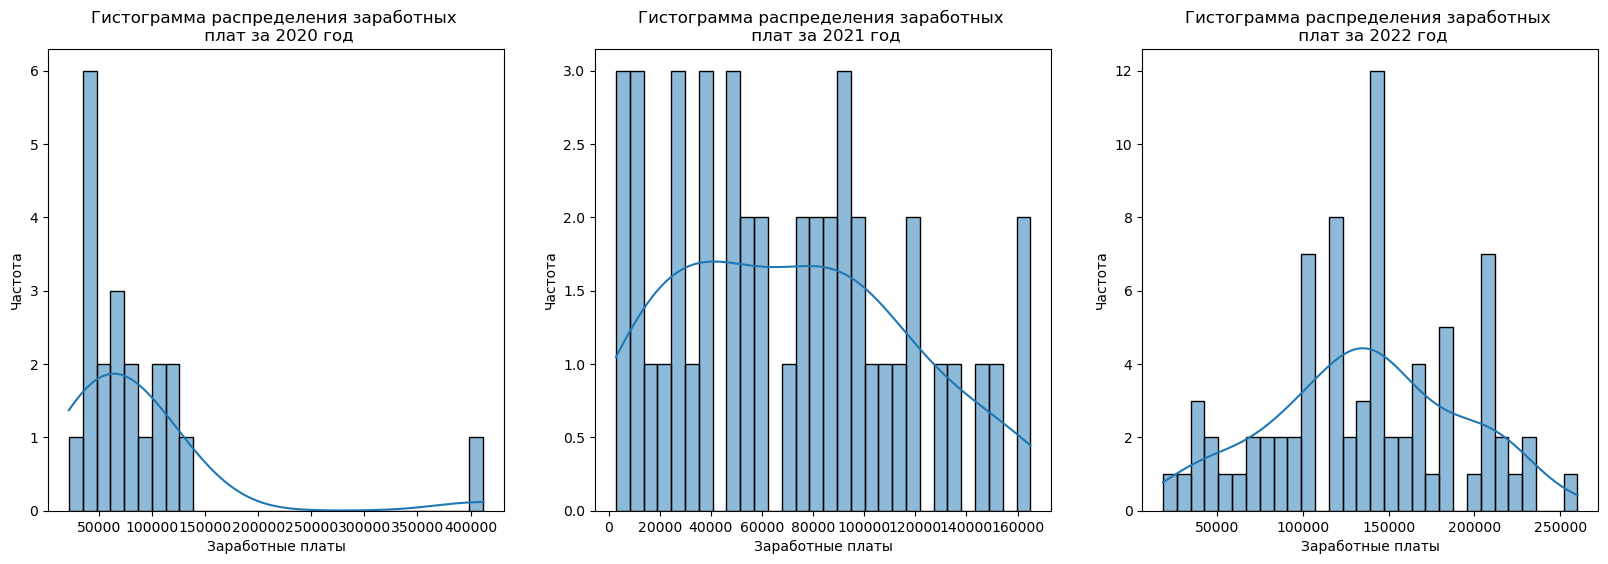

In [11]:
fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (20, 6))

sns.histplot(data_salary_2020, bins = 30, kde = True, ax = axes[0])
axes[0].set(xlabel = 'Заработные платы', ylabel = 'Частота')
axes[0].set_title('Гистограмма распределения заработных \n плат за 2020 год');

sns.histplot(data_salary_2021, bins = 30, kde = True, ax = axes[1])
axes[1].set(xlabel = 'Заработные платы', ylabel = 'Частота')
axes[1].set_title('Гистограмма распределения заработных \n плат за 2021 год');

sns.histplot(data_salary_2022, bins = 30, kde = True, ax = axes[2])
axes[2].set(xlabel = 'Заработные платы', ylabel = 'Частота')
axes[2].set_title('Гистограмма распределения заработных \n плат за 2022 год');

Вид данных гистограмм вызывает ряд сомнений в нормальности распределения представленных данных. Чтобы избавиться от сомнений прибегнем к графическому методу проверки **квантиль-квантиль график**.

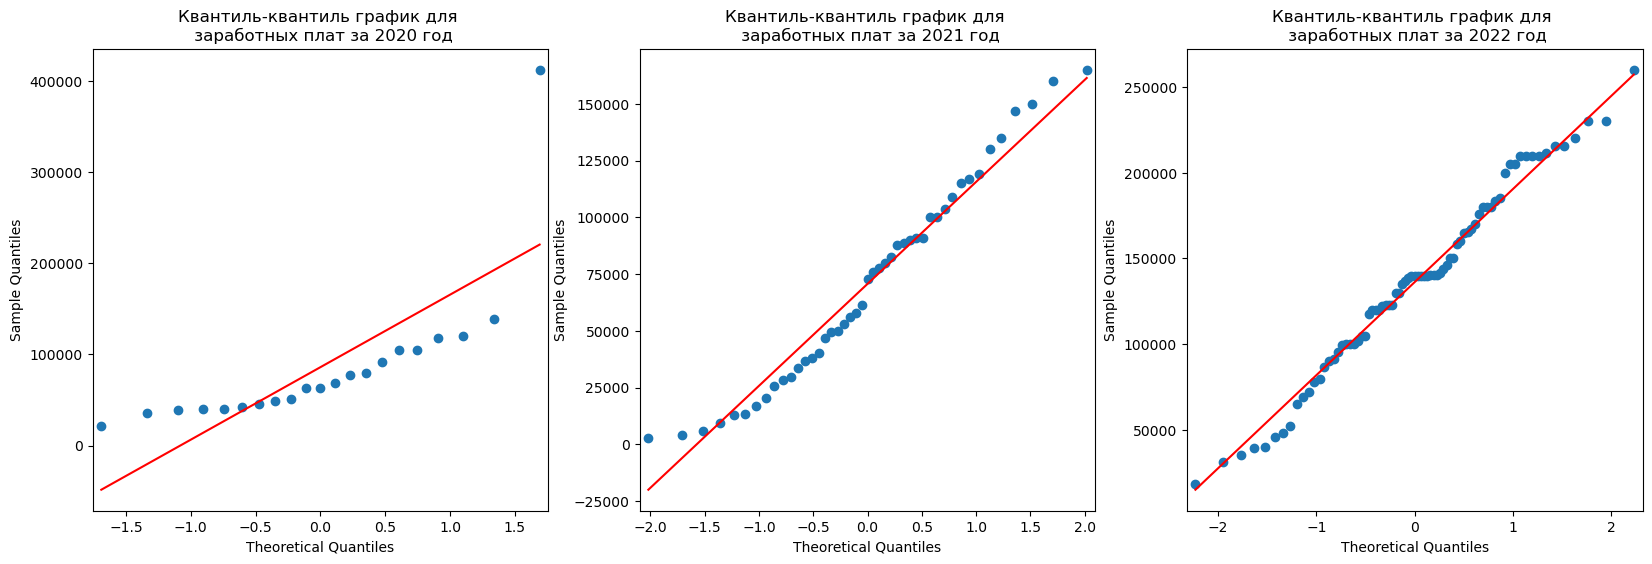

In [12]:
fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (20, 6))

sm.qqplot(data_salary_2020, line = 's', ax = axes[0])
axes[0].set_title('Квантиль-квантиль график для \n заработных плат за 2020 год');

sm.qqplot(data_salary_2021, line = 's', ax = axes[1])
axes[1].set_title('Квантиль-квантиль график для \n заработных плат за 2021 год');

sm.qqplot(data_salary_2022, line = 's', ax = axes[2])
axes[2].set_title('Квантиль-квантиль график для \n заработных плат за 2022 год');

**Квантиль-квантиль график** подтвертил наши опасения, данные представленные к анализу имеют близкое, но всё же не *прям вот* нормальное распределение. Чтобы закрепиться в своих убеждениях проведем финальный тест: **тест Шапиро-Уилка**.

Поскольку в ограничениях метода **ANOVA** сказано, что нормальным распределением должны обладать все выборки без исключения, проверим только одну группу данных, а именно за 2020 год.

Позволю себе напомнить, что в качестве **нулевой гипотезы** выступает утверждение: *данные обладают нормальным распределением*. В качестве же **альтернативной гипотезы**: *данные не обладают нормальным распределением*.

In [13]:
_, p = stats.shapiro(data_salary_2020)

print(f'p-value = {round(p, 3)}')

if p <= alpha:
    print('Данные не обладают нормальным распределением')
else:
    print('Данные обладают нормальным распределением')

p-value = 0.0
Данные не обладают нормальным распределением


Что ж, тест **Шапиро-Уилко** полностью подтвердил наши утверждения. Одна из групп данных не имеет нормального распределения. Следовательно сей факт вынуждает нас прибегнуть к непараметрическому аналогу теста **ANOVA** → **Критерию Краскела-Уоллиса**.

**Нулевой гипетозой** будет утверждение: *медианы заработных плат в 2020, 2021, 2022 году равны*.

В качестве **альтернативной гипотезы** заявим, что *медианы заработных плат в 2020, 2021 и 2022 году не равны*. 

In [14]:
_, p = stats.kruskal(data_salary_2020, data_salary_2021, data_salary_2022)
print(f'p-value = {round(p, 3)}')

if p <= alpha:
    print(f'p-значение меньше, чем заданный уровень значимости {alpha}. Следовательно медианы заработных плат за 2020, 2021 и 2022 год не\nравны. Мы можем отвергнуть нулевую гипотезу.')
else:
    print(f'p-значение больше, чем заданный уровень значимости {alpha}. Следовательно медианы заработных плат за 2020, 2021 и 2022 равны. У нас нет оснований отвергать нулевую гипотезу.')

p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Следовательно медианы заработных плат за 2020, 2021 и 2022 год не
равны. Мы можем отвергнуть нулевую гипотезу.


Узнав, что наши данные в годовом разрезе всё-таки отличаются, мы можем их сравнить. Для этого поочерёдно сравним медианы заработных плат по годам между собой.

Для начала сравним медиану заработной платы за **2020** и **2021** года, а затем за **2021** и **2022**.

В данном случае прибегнем к **U-критерию Манна-Уитни**. 

### <center> Критерий Манна-Уитни <center/>
### Сравнение данных за 2020 и 2021 год

Вспоминая гистограмму распределения заработной платы специалистов **Data Scientist** - гипотезы будут звучать следующим образом:
+ **нулевая гипотеза**: *заработная плата в 2020 меньше или равна заработной плате за 2021 год*.
+ **альтернативная гипотеза**: *заработная плата в 2020 году больше, чем в 2021*.

In [15]:
_, p = stats.mannwhitneyu(data_salary_2020, data_salary_2021, alternative = 'greater')
print(f'p-value = {round(p, 3)}')

if p <= alpha:
    print(f'p-значение меньше, чем заданный уровень значимости {alpha}. Зароботная плата в 2020 году больше, чем в 2021. Отвергаем нулевую гипотезу.')
else:
    print(f'p-значение больше, чем заданный уровень значимости {alpha}. Зароботная плата в 2020 году меньше, чем в 2021. У нас нет оснований отвергать нулевую гипотезу.')

p-value = 0.32
p-значение больше, чем заданный уровень значимости 0.05. Зароботная плата в 2020 году меньше, чем в 2021. У нас нет оснований отвергать нулевую гипотезу.


### Сравение данных за 2021 и 2022 год

Согласно предыдущему тесту - заработная плата в 2021 году больше, чем в 2020, следовательно, с данными за 2022 год мы будем сравнивать данные за 2021 год.

**Нулевая гипотеза**: *заработная плата за 2022 год меньше или равна заработной плате за 2021 год*.

**Альтернативная гипотеза**: *заработная плата за 2022 год больше, чем за 2021 год*.

In [16]:
_, p = stats.mannwhitneyu(data_salary_2022, data_salary_2021, alternative = 'greater')
print(f'p-value = {round(p, 3)}')

if p <= alpha:
    print(f'p-значение меньше, чем заданный уровень значимости {alpha}. Зароботная плата в 2022 году больше, чем в 2021. Отвергаем нулевую гипотезу.')
else:
    print(f'p-значение больше, чем заданный уровень значимости {alpha}. Зароботная плата в 2022 году меньше, чем в 2021. У нас нет оснований отвергать нулевую гипотезу.')

p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Зароботная плата в 2022 году больше, чем в 2021. Отвергаем нулевую гипотезу.


Согласно полученным нами результатам: медиана заработной платы за 2021 год больше, чем за 2020, а медиана заработной платы за 2022 год больше, чем за 2021 год, то есть:
+ 2020 < 2021 < 2022.

Тем самым, мы можем сказать, что у специалистов **Data Scientist** действительно наблюдается ежегодный прирост заработных плат.

**Однако**, глядя на полученные результаты, невольно появляется вопрос: почему полученные на основании **статистических тестов** результаты не соответствуют гистограмме распределения средних заработных плат специалистов **Data Scientist**. 

Ответ заключается в том, что вышеуказанная гистограмма отображает средние значения в годовом разрезе. А как мы помним из лекционного курса, данные о заработной плате редко, когда обладают **нормальным распределением**. В такой ситуации намного лучше анализировать, например, медианные значения, так как они **более устойчивы** к выбросам.

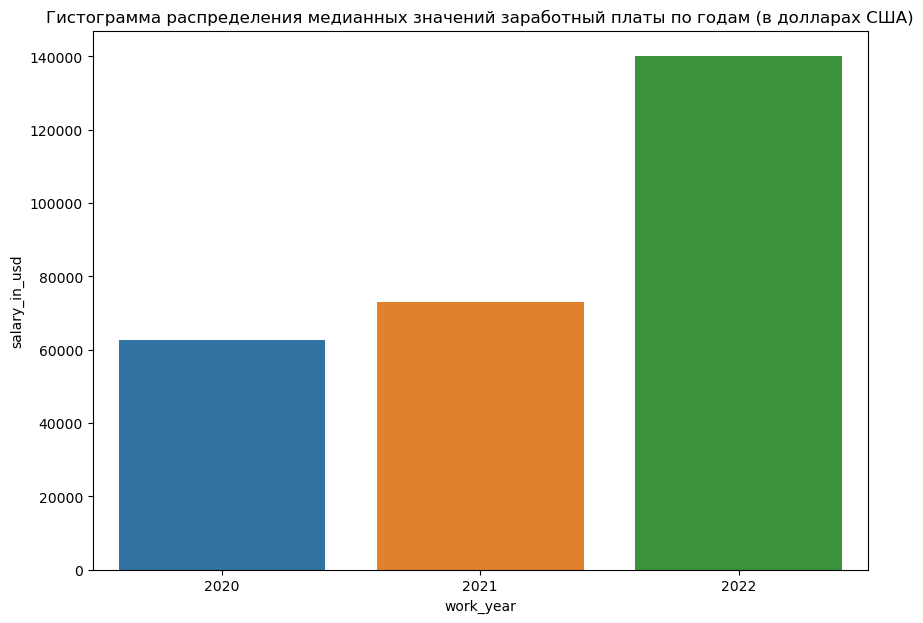

In [17]:
year_salary = data_salary[data_salary['job_title'] == 'Data Scientist'][['work_year', 'salary_in_usd']].groupby('work_year', as_index = False).median()

fig = plt.figure(figsize = (10, 7))

barplot = sns.barplot(
    data = year_salary,
    x = 'work_year',
    y = 'salary_in_usd'
)
barplot.set_title('Гистограмма распределения медианных значений заработный платы по годам (в долларах США)');

### Сравнение средних и медианных значений заработных плат в годовом разрезе

In [18]:
print(f'Данные за 2020 год: средняя заработная плата = {round(data_salary_2020.mean(), 1)}, а медианная = {data_salary_2020.median()}')
print(f'Данные за 2020 год: средняя заработная плата = {round(data_salary_2021.mean(), 1)}, а медианная = {data_salary_2021.median()}')
print(f'Данные за 2020 год: средняя заработная плата = {round(data_salary_2022.mean(), 1)}, а медианная = {data_salary_2022.median()}')

Данные за 2020 год: средняя заработная плата = 85970.5, а медианная = 62726.0
Данные за 2020 год: средняя заработная плата = 70671.7, а медианная = 73000.0
Данные за 2020 год: средняя заработная плата = 136172.1, а медианная = 140000.0


**Вывод к задаче №1**: мы можем с уверенностью заявить, что для специалистов **Data Scientist** наблюдается ежегодный рост заработной платы.

**Однако!** Я считаю, что сравнивать совокупные данные по заработным платам по годам *не очень-то* и корректно. Так, например, нам известно, что сотрудники с большим опытом работы нередко имеют более высокие заработные платы. А ведь соотношение соискателей с разным опытом работы может меняться год от года. Давайте это проверим. 

### Соотношение соискателей с разным опытом работы по годам

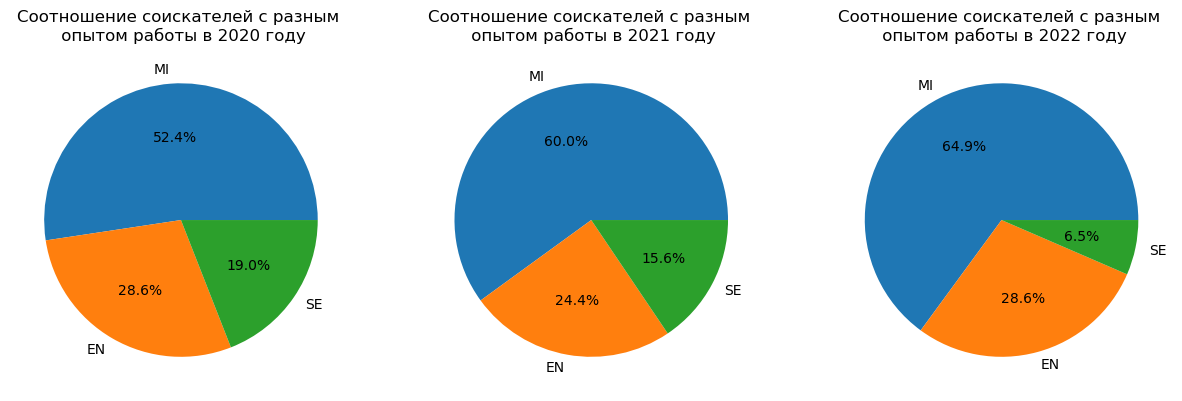

In [19]:
fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (15, 5))

axes[0].pie(
    data_salary[(data_salary['work_year'] == 2020) & (data_salary['job_title'] == 'Data Scientist')]['experience_level'].value_counts(),
    labels = data_salary[(data_salary['work_year'] == 2020) & (data_salary['job_title'] == 'Data Scientist')]['experience_level'].value_counts().index,
    autopct ='%.1f%%'
);
axes[0].set_title('Соотношение соискателей с разным \n опытом работы в 2020 году');

axes[1].pie(
    data_salary[(data_salary['work_year'] == 2021) & (data_salary['job_title'] == 'Data Scientist')]['experience_level'].value_counts(),
    labels = data_salary[(data_salary['work_year'] == 2020) & (data_salary['job_title'] == 'Data Scientist')]['experience_level'].value_counts().index,
    autopct ='%.1f%%'
);
axes[1].set_title('Соотношение соискателей с разным \n опытом работы в 2021 году');

axes[2].pie(
    data_salary[(data_salary['work_year'] == 2022) & (data_salary['job_title'] == 'Data Scientist')]['experience_level'].value_counts(),
    labels = data_salary[(data_salary['work_year'] == 2020) & (data_salary['job_title'] == 'Data Scientist')]['experience_level'].value_counts().index,
    autopct ='%.1f%%'
);
axes[2].set_title('Соотношение соискателей с разным \n опытом работы в 2022 году');

На представленных круговых диаграммах отчётливо видно, что соотношение соискателей с разным опытом работы **весьма непостоянно** год от года. И для того, чтобы получить ясный ответ на поставленный в *первой задаче* вопрос, наилучшим решением будет провести анализ заработных плат, опираясь **как минимум** на деление соискателей в зависимости от опыта работы.

Если же снова попытаться получить ответ на поставленный вопрос **в лоб** при помощи сводной таблицы, то можно увидеть, что средняя зарплата для специалистов категорий **EN** и **SE** в 2021 году снизилась по сравнению с 2020 годом. В то время как специалисты с категорией **MI** в 2021 году получили прибавку. А в 2022 году прибавку уже получили **все**.

In [20]:
data_salary_DS = data_salary[data_salary['job_title'] == 'Data Scientist']
display(round(data_salary_DS.pivot_table(
    values = 'salary_in_usd',
    index = 'experience_level',
    columns = 'work_year',
    aggfunc = 'median'
), 1))

work_year,2020,2021,2022
experience_level,,,
EN,50294.5,49646.0,52396.0
MI,62726.0,73000.0,95807.0
SE,105618.5,87738.0,148000.0


**Аналогичная** ситуация наблюдается, если анализировать данные в разрезе размера фирмы, в которой работал соискатель. В данной ситуации также **нельзя** утвердительно сказать, что для всех соискателей наблюдается ежегодный прирост заработной платы.

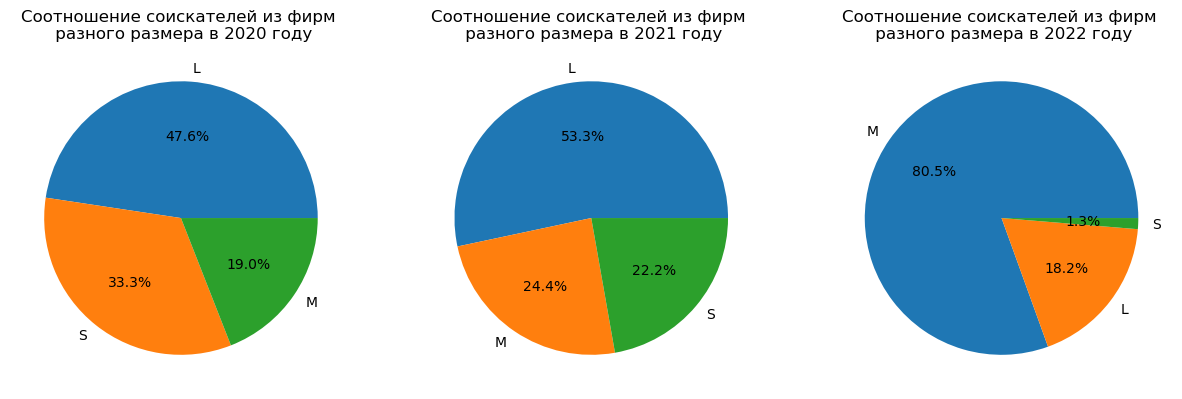

In [21]:
fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (15, 5))

axes[0].pie(
    data_salary[(data_salary['work_year'] == 2020) & (data_salary['job_title'] == 'Data Scientist')]['company_size'].value_counts(),
    labels = data_salary[data_salary['work_year'] == 2020]['company_size'].value_counts().index,
    autopct ='%.1f%%'
);
axes[0].set_title('Соотношение соискателей из фирм \n разного размера в 2020 году');

axes[1].pie(
    data_salary[(data_salary['work_year'] == 2021) & (data_salary['job_title'] == 'Data Scientist')]['company_size'].value_counts(),
    labels = data_salary[data_salary['work_year'] == 2021]['company_size'].value_counts().index,
    autopct ='%.1f%%'
);
axes[1].set_title('Соотношение соискателей из фирм \n разного размера в 2021 году');

axes[2].pie(
    data_salary[(data_salary['work_year'] == 2022) & (data_salary['job_title'] == 'Data Scientist')]['company_size'].value_counts(),
    labels = data_salary[data_salary['work_year'] == 2022]['company_size'].value_counts().index,
    autopct ='%.1f%%'
);
axes[2].set_title('Соотношение соискателей из фирм \n разного размера в 2022 году');

In [22]:
display(round(data_salary[data_salary['job_title'] == 'Data Scientist'].pivot_table(
    values = 'salary_in_usd',
    index = 'company_size',
    columns = 'work_year',
    aggfunc = 'mean'
), 1))

work_year,2020,2021,2022
company_size,,,
L,123068.1,83157.4,127989.1
M,83760.5,68261.1,139442.0
S,60886.2,43357.9,48000.0


**Вывод:** чтобы сделать наиболее корректные выводы по **Задаче №1**, необходимо проводить более глубокую аналитику данных в разрезе различных факторов, представленных в входных данных.

*Так же было бы весьма интересно узнать, что вызвало спад заработных плат в 2021 году*.

## <center> Задача №2: *Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?*</center>

Как нам известно из курса лекций, для анализа двух независимых групп используется **двухвыборочный t-критерий** или его непараметрический аналог **U-критерий Манна-Иутни**. 

**Двухвыборочный t-критерий** можно использовать только, если данные в наших выборках распределены нормально. В *курсе лекций* неоднакратно заявлялось, что данные о заработных платах **редко имеют нормальное распределение**, но я всё же считаю, что лучше проверить данные самостоятельно. Выполним весь спектр проверок от визуальных и графических до математических.

Для начала создадим две необходимые нам выборки:

In [23]:
mask_DS = (data_salary['job_title'] == 'Data Scientist') & (data_salary['work_year'] == 2022)
mask_DE = (data_salary['job_title'] == 'Data Engineer') & (data_salary['work_year'] == 2022)

data_salary_DE = data_salary[mask_DE]['salary_in_usd']
data_salary_DS = data_salary[mask_DS]['salary_in_usd']

### Визаульная проверка при помощи гистограмм

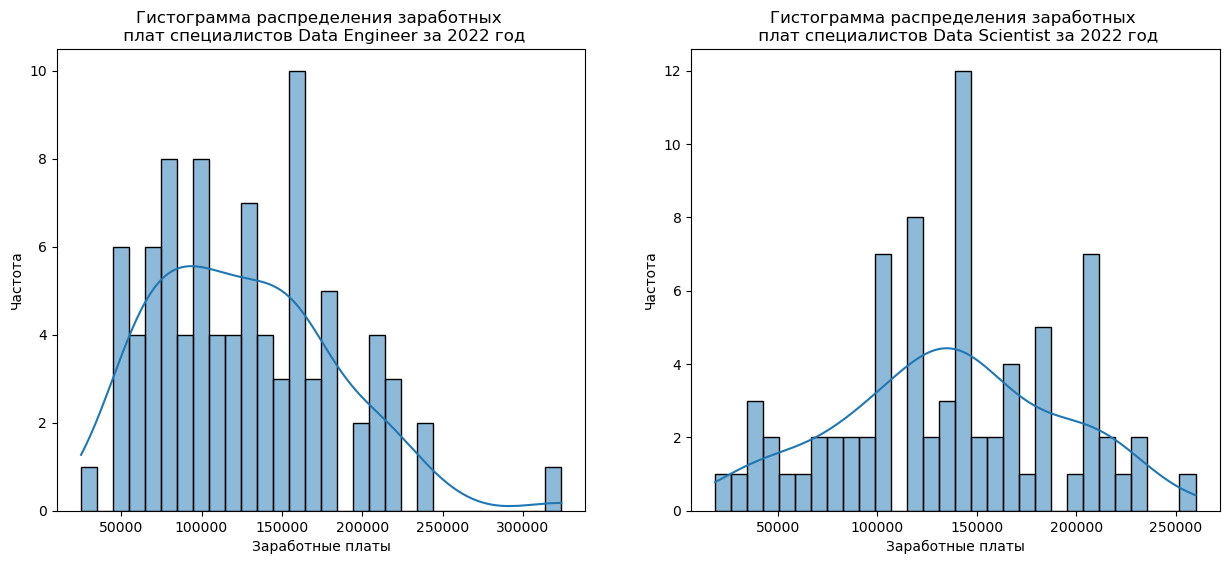

In [24]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 6))

sns.histplot(data_salary_DE, bins = 30, kde = True, ax = axes[0])
axes[0].set(xlabel = 'Заработные платы', ylabel = 'Частота')
axes[0].set_title('Гистограмма распределения заработных \n плат специалистов Data Engineer за 2022 год');

sns.histplot(data_salary_DS, bins = 30, kde = True, ax = axes[1])
axes[1].set(xlabel = 'Заработные платы', ylabel = 'Частота')
axes[1].set_title('Гистограмма распределения заработных \n плат специалистов Data Scientist за 2022 год');

Хм, представленные гистограммы на первый взгляд имеют нормальное распределение, или *что-то похожее* на нормальное распределение.

Прибегнем к методу **квантиль-квантиль график**.

### Графическая проверка при помощи "квантиль-квантиль графиков"

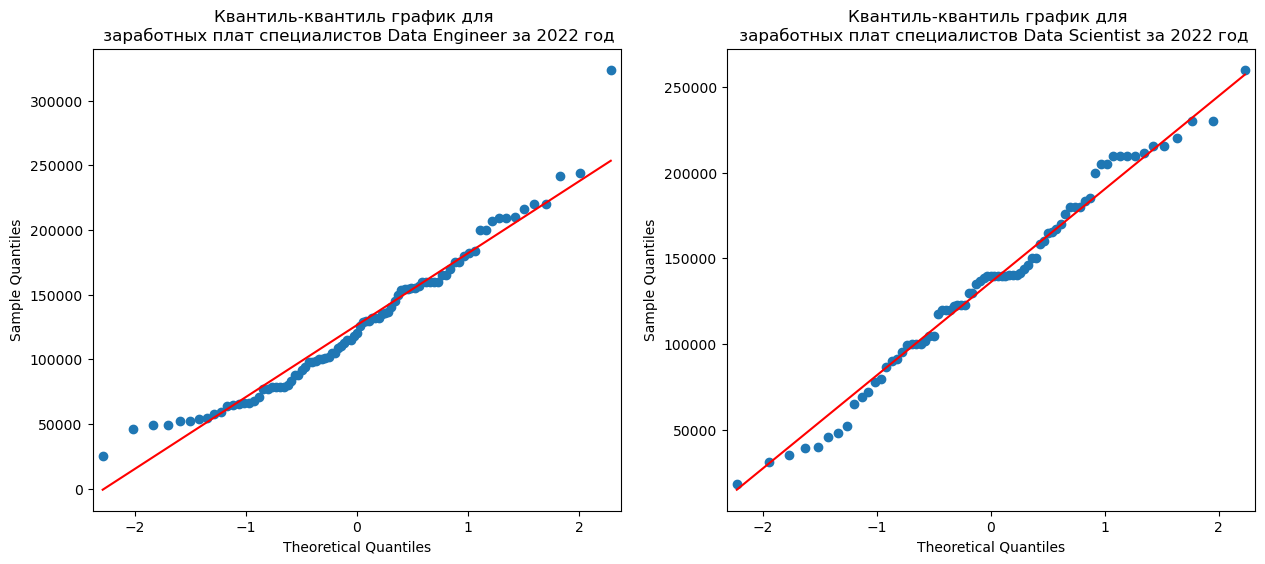

In [25]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 6))

sm.qqplot(data_salary_DE, line = 's', ax = axes[0])
axes[0].set_title('Квантиль-квантиль график для \n заработных плат специалистов Data Engineer за 2022 год');

sm.qqplot(data_salary_DS, line = 's', ax = axes[1])
axes[1].set_title('Квантиль-квантиль график для \n заработных плат специалистов Data Scientist за 2022 год');

*Подозрительно*, но на **квантиль-квантиль графиках** мы тоже видим *почти что* нормальное распределение представленных данных.
Чтобы получить точный ответ прибегнем к **тесту Шапиро-Уилка**, где **нулевая гипотеза** гласит, что *данные обладают нормальным распределением*, а **альтернативная** - *нет*.

### Математическая проверка при помощи теста "Шапиро-Уилка"

In [26]:
_, p = stats.shapiro(data_salary_DE)

print(f'p-value выборки по специалистам Data Enginner = {round(p, 3)}')

if p <= alpha:
    print('Данные о заработных платах специалистоа Data Engineer не обладают нормальным распределением')
else:
    print('Данные о заработных платах специалистоа Data Engineer обладают нормальным распределением')
    
print()

_, p = stats.shapiro(data_salary_DS)

print(f'p-value выборки по специалистам Data Scientist = {round(p, 3)}')

if p <= alpha:
    print('Данные о заработных платах специалистоа Data Scientist не обладают нормальным распределением')
else:
    print('Данные о заработных платах специалистоа Data Scientist обладают нормальным распределением')

p-value выборки по специалистам Data Enginner = 0.01
Данные о заработных платах специалистоа Data Engineer не обладают нормальным распределением

p-value выборки по специалистам Data Scientist = 0.327
Данные о заработных платах специалистоа Data Scientist обладают нормальным распределением


*Занимательный* результат! Данные о заработных платах специалистов **Data Scientist** всё же обладают нормальным распределением, но для теста **двухвыборочного t-критерия** этого недостаточно. Нормальным распределением должны обладать все участвующие в исследованиях выборки.

В силу вышеперечисленных фактов, прибегнем к **U-критерию Манна-Уитни**. 

В качестве **нулевой гипотезы** заявим, *что заработные платы специалистов Data Engineer меньше или равны заработным платам специалистов Data Scientist*. Соответственно, **альтернативная гипотеза** будет утвержать, что *заработные платы специалистов Data Engineer больше, чем заработные платы специалистов Data Scientist*. 

In [27]:
_, p = stats.mannwhitneyu(data_salary_DE, data_salary_DS, alternative = 'greater')
print(f'p-vaue = {round(p, 3)}')

if p <= alpha:
    print(f'p-значение меньше, чем заданный уровень значимости {alpha}. Заработная плата специалистов Data Engineer больше, чем заработная плата спеуциалистов Data Scientist. Отвергаем нулевую гипотезу.')
else:
    print(f'p-значение больше, чем заданный уровень значимости {alpha}. Заработная плата специалистов Data Engineer меньше, чем заработная плата спеуциалистов Data Scientist. У нас нет оснований отвергать нулевую гипотезу.')

p-vaue = 0.923
p-значение больше, чем заданный уровень значимости 0.05. Заработная плата специалистов Data Engineer меньше, чем заработная плата спеуциалистов Data Scientist. У нас нет оснований отвергать нулевую гипотезу.


Что ж, глядя на результаты статистического теста, мы уверенно можем заявить, что заработные платы специалистов **Data Scientist** больше, чем заработные платы специалистов **Data Engineer**.

Однако, было интересно ещё и узнать соотношение вышеупомянутых специалистов, ищущих работу в 2022 году. Для этого взглянем на круговую диаграмму:

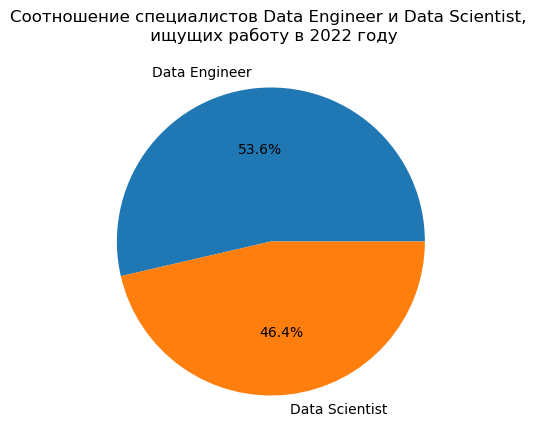

In [28]:
mask = ((data_salary['job_title'] == 'Data Scientist') | (data_salary['job_title'] == 'Data Engineer')) & (data_salary['work_year'] == 2022)

fig = plt.figure(figsize = (5, 5))

plt.pie(
    data_salary[mask]['job_title'].value_counts(),
    labels = data_salary[mask]['job_title'].value_counts().index,
    autopct ='%.1f%%'
);
plt.title('Соотношение специалистов Data Engineer и Data Scientist, \n ищущих работу в 2022 году');

На круговой диаграмме мы видим небольшой количественный перевес специлистов **Data Engineer**. Поэтому говорить, что специалисты **Data Engineer** имеют более низкую заработную плату в силу перенасущенности рынка данными специалистами - не приходится. 

Тогда, давайте посмотрим на опыт специалистов, решивших поменять работу в 2022 году. Для этого снова прибегнем к круговым диаграммам.

Для справки, укажу расшифровку иностранных обозначений:
+ **EN** - Entrylevel/Junior;
+ **MI** - Mid-level/Intermediate;
+ **SE** - Senior-level/Expert;
+ **EX** - Executive-level/Director.

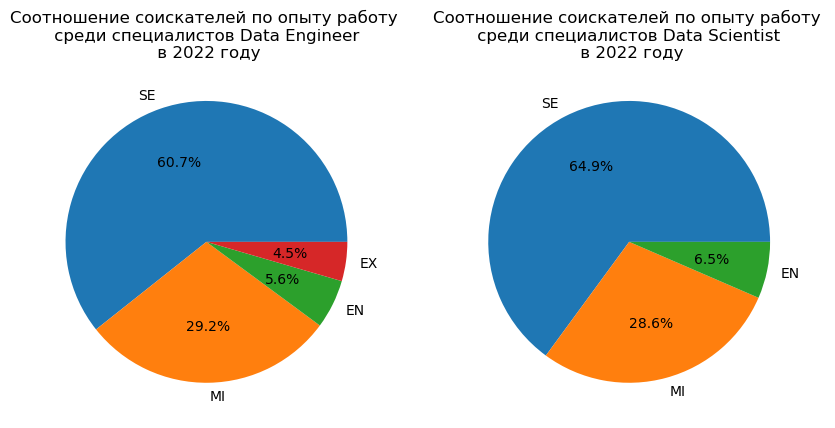

In [29]:
mask_DE = (data_salary['job_title'] == 'Data Engineer') & (data_salary['work_year'] == 2022)
mask_DS = (data_salary['job_title'] == 'Data Scientist') & (data_salary['work_year'] == 2022)

fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 5))

axes[0].pie(
    data_salary[mask_DE]['experience_level'].value_counts(),
    labels = data_salary[mask_DE]['experience_level'].value_counts().index,
    autopct ='%.1f%%'
);
axes[0].set_title('Соотношение соискателей по опыту работу \n среди специалистов Data Engineer \n в 2022 году');

axes[1].pie(
    data_salary[mask_DS]['experience_level'].value_counts(),
    labels = data_salary[mask_DS]['experience_level'].value_counts().index,
    autopct ='%.1f%%'
);
axes[1].set_title('Соотношение соискателей по опыту работу \n среди специалистов Data Scientist \n в 2022 году');

Здесь мы видим более интересные результаты. При почти равном распределении по опыту работы среди соискателей, в глаза бросается один немаловажный факт. Среди в специалистов-соискателей **Data Engineer** в 2022 году 4.5% составляют специалисты управляющего звена **EX**. По логике вещей, специалисты такого уровня имеют наивысшие заработные платы среди остальных. В то же время среди специалистов **Data Scientist** в 2022 не было соискателей руководящего звена (*или их должность в представленных данных называется как-то иначе*). Если сделать предположение, что специалисты *уровня* **EX** могут вносить весомый качественный вклад, то можно прийти к выводу, что специалисты **Data Scientist** в денежном эквиваленте ценятся больше, чем специалисты **Data Engineer**.

**Вывод к задаче №2**: заработная плата специалистов **Data Scientist** больше, чем заработная плата специалистов **Data Engineer**. *По крайней мере в 2022 году*.

## <center> Задача №3: *Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров*</center>

Как и всегда, для начала я попробую выполнить задачу **в лоб**. Для этого построю гистограмму распределения заработных плат специалистов **Data Scientist** в зависимости от размера фирмы.

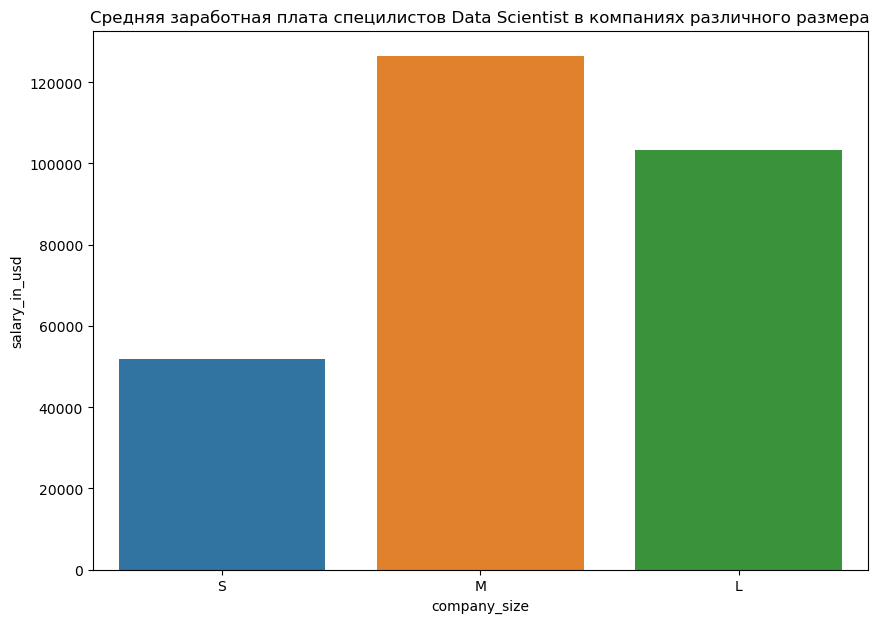

In [30]:
fig = plt.figure(figsize = (10, 7))

barplot = sns.barplot(
    data = data_salary[data_salary['job_title'] == 'Data Scientist'],
    x = 'company_size',
    y = 'salary_in_usd',
    order = ['S', 'M', 'L'],
    errorbar = None
)
barplot.set_title('Средняя заработная плата специлистов Data Scientist в компаниях различного размера');

Признаться, это немного неожиданный результат. Наибольшая средняя заработная плата наюлюдается у специалистов **Data Scientist** в фирмах среднего размера, где штат сотрудников лежит в пределах от 50 до 250 человек.

Интересно, а какой вклад в получаемые значения вносят сотрудники с **разным опытом работы**?

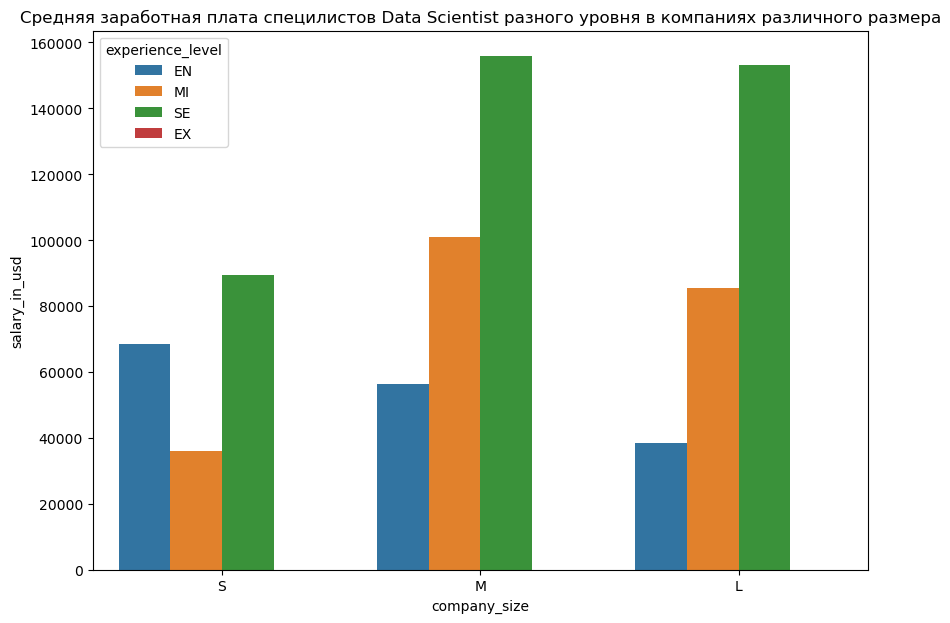

In [31]:
fig = plt.figure(figsize = (10, 7))

barplot = sns.barplot(
    data = data_salary[data_salary['job_title'] == 'Data Scientist'],
    x = 'company_size',
    y = 'salary_in_usd',
    hue = 'experience_level',
    order = ['S', 'M', 'L'],
    hue_order = ['EN', 'MI', 'SE', 'EX'],
    errorbar = None
)
barplot.set_title('Средняя заработная плата специлистов Data Scientist разного уровня в компаниях различного размера');

Снова получаем *весьма интересные* результаты, но о них чуть позже. На представленной ниже гистограмме отсутствуют специалисты с опытом работы **EX/Director**. Вряд ли никто из руководящего звена не искал работу в течение трёх лет. Вероятнее всего специалисты такого уровня имеет несколько иное наименование в признаке **job_title**. Данный факт необходимо проверить.

Проверять буду таким образом:
* получу список всех уникальных должностей;
* оставлю только те должности, которые имеют отношение к **Data Science**.

In [56]:
directors_list = data_salary['job_title'].unique()

for job_title in directors_list:
    if 'Data Scien' in job_title:
        print(job_title)
    else:
        pass

Data Scientist
Lead Data Scientist
Data Science Consultant
Director of Data Science
Principal Data Scientist
Data Science Manager
Applied Data Scientist
Data Science Engineer
Head of Data Science
Staff Data Scientist


Действительно, в полученном списке должностей есть похожая на правду **Director of Data Science**. Посмотрим - соответствует ли результат действительности.

In [33]:
display(data_salary[data_salary['job_title'] == 'Director of Data Science'])

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
25,2020,EX,FT,Director of Data Science,325000,US,100,US,L
84,2021,EX,FT,Director of Data Science,153667,IT,100,PL,L
150,2021,SE,FT,Director of Data Science,168000,JP,0,JP,S
164,2021,EX,FT,Director of Data Science,130026,DE,50,DE,M
167,2021,EX,FT,Director of Data Science,250000,US,0,US,L
259,2021,EX,FT,Director of Data Science,141846,DE,0,DE,L
452,2022,EX,FT,Director of Data Science,196979,CA,50,CA,L


Действительно так, все специалисты **Director of Data Science** *кроме одного* имеют опыт работы уровня **EX**. *На мой взгляд*, данный факт позволяет отнести данных специалистов к специалистам **Data Scientist**.

Взглянем на гистограмму распределения заработных плат специлистов **Data Scientist** с разным опытом работы в фирмах разного размера:

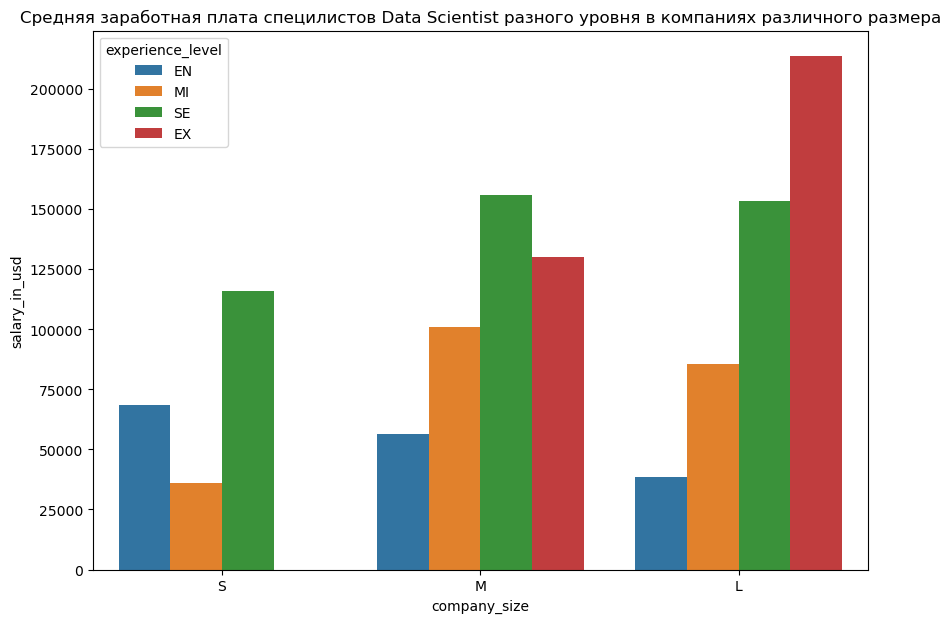

In [34]:
fig = plt.figure(figsize = (10, 7))

barplot = sns.barplot(
    data = data_salary[(data_salary['job_title'] == 'Data Scientist') | (data_salary['job_title'] == 'Director of Data Science')],
    x = 'company_size',
    y = 'salary_in_usd',
    hue = 'experience_level',
    order = ['S', 'M', 'L'],
    hue_order = ['EN', 'MI', 'SE', 'EX'],
    errorbar = None
)
barplot.set_title('Средняя заработная плата специлистов Data Scientist разного уровня в компаниях различного размера');

На представленной выше гистограмме можно выделить весьма интересные закономерности, а именно:
* молодому специалисту или специалисту без опыта, лучше начинать свой трудовой путь в небольшой компании. В целом наблюдается обратно пропорциональная зависимость: чем больше компания, тем меньше там заработная плата у специлистов уровня **EN**;
* специалистам с средним и большим опытом работы выгоднее работать в фирме среднего размера, так как средняя заработная плата в них наибольшая для специалистов уровня **MI** и **SE**;
* специалисты уровня **EX** либо очень хорошо устроились в маленьких фирмах, либо последние в них вовсе не нуждаются, так как данных о таком роде специалистов вовсе нет. Наилучшим вариантом для руководителей **EX** будет устроиться в большую компанию, где заработные платы для них на самом высоком уровне.

Посмотрии совокупное распределение заработных плат специалистов **Data Scientist** в зависимости от размера фирмы.

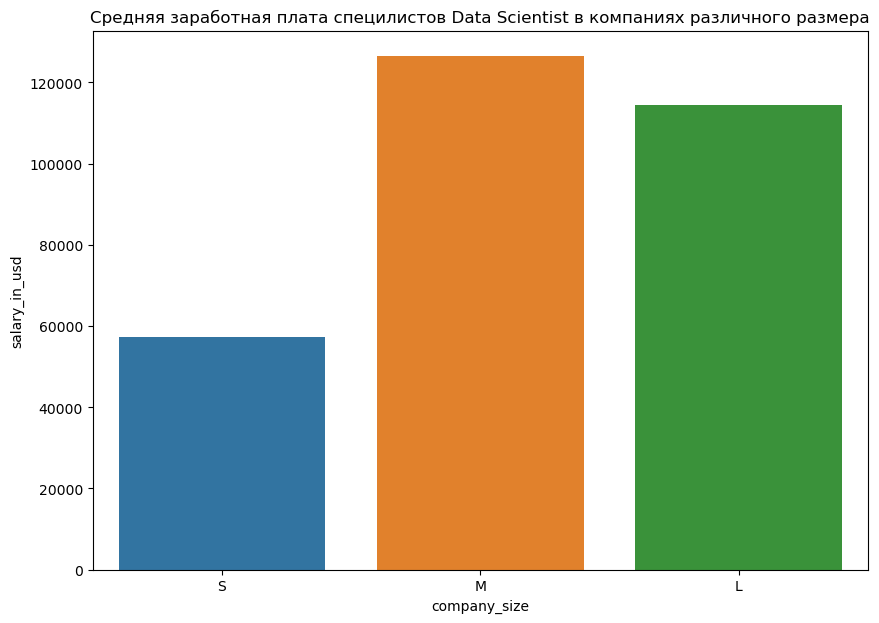

In [35]:
fig = plt.figure(figsize = (10, 7))

barplot = sns.barplot(
    data = data_salary[(data_salary['job_title'] == 'Data Scientist') | (data_salary['job_title'] == 'Director of Data Science')],
    x = 'company_size',
    y = 'salary_in_usd',
    order = ['S', 'M', 'L'],
    errorbar = None
)
barplot.set_title('Средняя заработная плата специлистов Data Scientist в компаниях различного размера');

На данной гистограмме мы видим значительное повышение средней заработной платы в больших компаниях **L** за счёт включения в выборку специалистов руководящего звена **EX**.

Дальнейшую проверку я буду проводить по аналогии с **задачей №1**:
+ применю **критерий Краскела-Уолисса**, чтобы определить статистическую значимость *неодинаковости* значений;
+ поочерёдно сравню значения заработных плат в компаниях разного размера.

Для начала сформируем необходимые нам выборки:

In [36]:
data_scientist_company_s = data_salary[((data_salary['job_title'] == 'Data Scientist') | (data_salary['job_title'] == 'Director of Data Science')) & (data_salary['company_size'] == 'S')]['salary_in_usd']
data_scientist_company_m = data_salary[((data_salary['job_title'] == 'Data Scientist') | (data_salary['job_title'] == 'Director of Data Science')) & (data_salary['company_size'] == 'M')]['salary_in_usd']
data_scientist_company_l = data_salary[((data_salary['job_title'] == 'Data Scientist') | (data_salary['job_title'] == 'Director of Data Science')) & (data_salary['company_size'] == 'L')]['salary_in_usd']

Хоть мы уже и убеждались неоднократно, что **данные по заработным платам редко, когда имеют нормальное распределение**, мы всё-таки обязаны выполнить данную **проверку** для *чистоты эксперимента*.

Не думаю, что есть необхоимость в полном спектре проверок при помощи **гистограмм** и **квантиль-квантиль графиков**. Однако, гистограммы я построю для личного ознакомления, а проверку проведу при помощи **теста Шапиро-Уилка**.

### Гистограммы распределения заработных плат в зависимости от размера компании

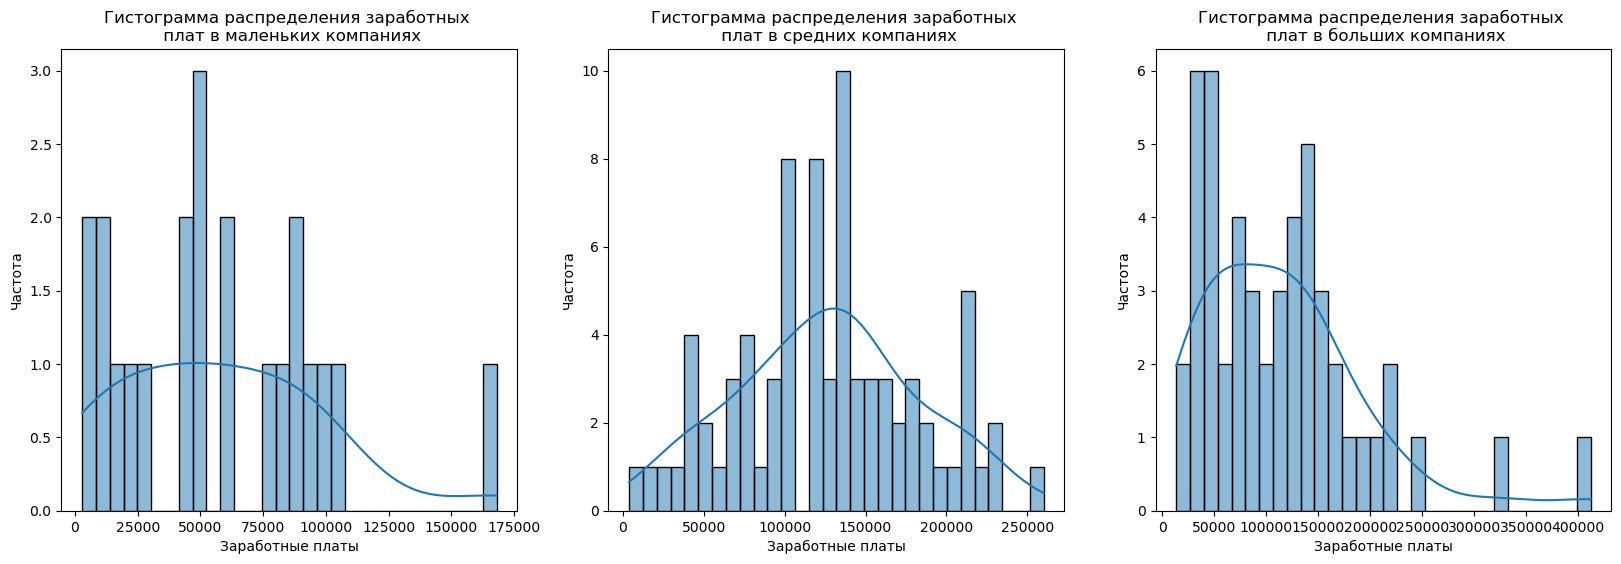

In [37]:
fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (20, 6))

sns.histplot(data_scientist_company_s, bins = 30, kde = True, ax = axes[0])
axes[0].set(xlabel = 'Заработные платы', ylabel = 'Частота')
axes[0].set_title('Гистограмма распределения заработных \n плат в маленьких компаниях');

sns.histplot(data_scientist_company_m, bins = 30, kde = True, ax = axes[1])
axes[1].set(xlabel = 'Заработные платы', ylabel = 'Частота')
axes[1].set_title('Гистограмма распределения заработных \n плат в средних компаниях');

sns.histplot(data_scientist_company_l, bins = 30, kde = True, ax = axes[2])
axes[2].set(xlabel = 'Заработные платы', ylabel = 'Частота')
axes[2].set_title('Гистограмма распределения заработных \n плат в больших компаниях');

### Тест Шапиро-Уилка

In [38]:
_, p = stats.shapiro(data_scientist_company_s)

print(f'p-value выборки по специалистам Data Scientist в маленьких компаниях = {round(p, 3)}')

if p <= alpha:
    print('Данные о заработных платах специалистоа Data Scientist в маленьких компаниях не обладают нормальным распределением')
else:
    print('Данные о заработных платах специалистоа Data Scientist в маленьких компаниях обладают нормальным распределением')
    
print()

_, p = stats.shapiro(data_scientist_company_m)

print(f'p-value выборки по специалистам Data Scientist в средних компаниях = {round(p, 3)}')

if p <= alpha:
    print('Данные о заработных платах специалистоа Data Scientist в средних компаниях не обладают нормальным распределением')
else:
    print('Данные о заработных платах специалистоа Data Scientist в средних компаниях обладают нормальным распределением')
    
print()

_, p = stats.shapiro(data_scientist_company_l)

print(f'p-value выборки по специалистам Data Scientist в больших компаниях = {round(p, 3)}')

if p <= alpha:
    print('Данные о заработных платах специалистоа Data Scientist в больших компаниях не обладают нормальным распределением')
else:
    print('Данные о заработных платах специалистоа Data Scientist в больших компаниях обладают нормальным распределением')

p-value выборки по специалистам Data Scientist в маленьких компаниях = 0.156
Данные о заработных платах специалистоа Data Scientist в маленьких компаниях обладают нормальным распределением

p-value выборки по специалистам Data Scientist в средних компаниях = 0.636
Данные о заработных платах специалистоа Data Scientist в средних компаниях обладают нормальным распределением

p-value выборки по специалистам Data Scientist в больших компаниях = 0.0
Данные о заработных платах специалистоа Data Scientist в больших компаниях не обладают нормальным распределением


**Однако!** Две из трёх выборок обладают нормальным распределением! Но тем не менее основное ограничение метода **ANOVA** требует, чтобы все выборки без исключения обладали **нормальным** распределением.

Поэтому как и ранее, прибегнем к **Критерию Краскела-Уоллиса**:
+ **нулевая гипотеза**: *медианы заработных плат в фирмах разного размера равны*;
+ **альтернативная гипотеза**: *медианы заработных плат в фирмах разного не равны*.

In [39]:
_, p = stats.kruskal(data_scientist_company_s, data_scientist_company_m, data_scientist_company_l)
print(f'p-value = {round(p, 3)}')

if p <= alpha:
    print(f'p-значение меньше, чем заданный уровень значимости {alpha}. Следовательно медианы заработных плат в фирмах различного размера не\nравны. Мы можем отвергнуть нулевую гипотезу.')
else:
    print(f'p-значение больше, чем заданный уровень значимости {alpha}. Следовательно медианы заработных плат в фирмах различного размера равны. У нас нет оснований отвергать нулевую гипотезу.')

p-value = 0.0
p-значение меньше, чем заданный уровень значимости 0.05. Следовательно медианы заработных плат в фирмах различного размера не
равны. Мы можем отвергнуть нулевую гипотезу.


Убедившись в том, что данные есть смысл сравнивать, мы можем приступать к сравнению при помощи **критерия Манна-Уитни**.

### <center> Критерий Манна-Уитни <center/>
    
### Сравнение данных о фирмах маленького и большого размера:

Опираясь на данные, полученные при помощи гистограммы, первыми выборками для сравнения будут выборки по маленьким и большим компаниям.
    
**Нулевая гипотеза**: *заработная плата в больших фирмах меньше или равна заработной плате в маленьких компаниях*;

**Альтернативная гипотеза**: *зароботная плата в больших фирмах больше заработной платы в маленьких фирмах*.

In [40]:
_, p = stats.mannwhitneyu(data_scientist_company_s, data_scientist_company_l, alternative = 'less')
print(f'p-value = {round(p, 3)}')

if p <= alpha:
    print(f'p-значение меньше, чем заданный уровень значимости {alpha}. Зароботная плата в больших фирмах больше, чем в маленьких. Отвергаем нулевую гипотезу.')
else:
    print(f'p-значение больше, чем заданный уровень значимости {alpha}. Зароботная плата в больших фирмах меньше, чем в маленьких. У нас нет оснований отвергать нулевую гипотезу.')

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Зароботная плата в больших фирмах больше, чем в маленьких. Отвергаем нулевую гипотезу.


### Сравнение данных о фирмах среднего и большого размера:

Всё также опираясь на данные гистограммы, в данном случае сравним выборки по средним и большм компаниям.

**Нулевая гипотеза**: *заработная плата в средних фирмах меньше или равна заработной плате в больших фирмах*;
**Альтернативная гипотеза**: *заработная плата в средних фирмах больше заработной платы в больших фирмах*.

In [41]:
_, p = stats.mannwhitneyu(data_scientist_company_m, data_scientist_company_l, alternative = 'greater')
print(f'p-value = {round(p, 3)}')

if p <= alpha:
    print(f'p-значение меньше, чем заданный уровень значимости {alpha}. Зароботная плата в средних фирмах больше, чем в больших. Отвергаем нулевую гипотезу.')
else:
    print(f'p-значение больше, чем заданный уровень значимости {alpha}. Зароботная плата в средних фирмах меньше, чем в больших. У нас нет оснований отвергать нулевую гипотезу.')

p-value = 0.044
p-значение меньше, чем заданный уровень значимости 0.05. Зароботная плата в средних фирмах больше, чем в больших. Отвергаем нулевую гипотезу.


**Вывод к задаче №3:** если вы начинающий специалист **Data Scientist**, то свой путь выгоднее начинать в маленьких фирмах, а набравшись опыта, перебраться к компанию побольше. В большую компанию стоит уходить только, если вы занимаете высокую руководящую должность.

**Однако**, я бы ещё взглянул на такие данные, как:
+ соотношение сотрудников по типу трудоустройства в компаниях различного размера;
+ соотношение сотрудников по количеству удалённой работы.

Вероятнее всего это тоже может оказывать влияние на распределение заработных плат в различных по размеру фирмах.

### Соотношение сотрудников по типу трудоустройства

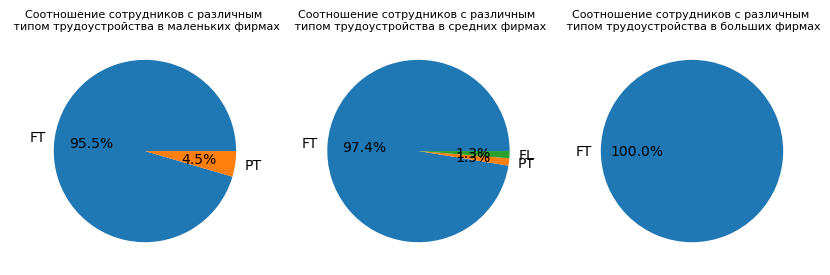

In [42]:
data_scientist_company_s = data_salary[((data_salary['job_title'] == 'Data Scientist') | (data_salary['job_title'] == 'Director of Data Science')) & (data_salary['company_size'] == 'S')]
data_scientist_company_m = data_salary[((data_salary['job_title'] == 'Data Scientist') | (data_salary['job_title'] == 'Director of Data Science')) & (data_salary['company_size'] == 'M')]
data_scientist_company_l = data_salary[((data_salary['job_title'] == 'Data Scientist') | (data_salary['job_title'] == 'Director of Data Science')) & (data_salary['company_size'] == 'L')]


fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (10, 5))

axes[0].pie(
    data_scientist_company_s['employment_type'].value_counts(),
    labels = data_scientist_company_s['employment_type'].value_counts().index,
    autopct ='%.1f%%'
);
axes[0].set_title('Соотношение сотрудников с различным \n типом трудоустройства в маленьких фирмах', fontsize = 8);

axes[1].pie(
    data_scientist_company_m['employment_type'].value_counts(),
    labels = data_scientist_company_m['employment_type'].value_counts().index,
    autopct ='%.1f%%'
);
axes[1].set_title('Соотношение сотрудников с различным \n типом трудоустройства в средних фирмах', fontsize = 8);

axes[2].pie(
    data_scientist_company_l['employment_type'].value_counts(),
    labels = data_scientist_company_l['employment_type'].value_counts().index,
    autopct ='%.1f%%'
);
axes[2].set_title('Соотношение сотрудников с различным \n типом трудоустройства в больших фирмах', fontsize = 8);

Для удобства восприятия приведу дешифровку обозначений для круговых диаграмм:
+ **PT** - неполный рабочий день;
+ **FT** - полный рабочий день;
+ **CT** - контракт;
+ **FL** - фриланс.

**Вывод**: данный анализ не имеет какого-либо смысла, так как **подавляющее** большинство специалистов **Data Scientist** работают во всех фирмах **полный рабочий день**.

### Соотношение сотрудников по количеству удалённой работы

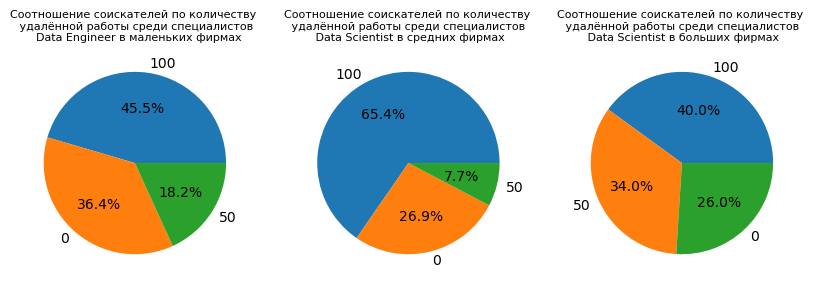

In [43]:
fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (10, 5))

axes[0].pie(
    data_scientist_company_s['remote_ratio'].value_counts(),
    labels = data_scientist_company_s['remote_ratio'].value_counts().index,
    autopct ='%.1f%%'
);
axes[0].set_title('Соотношение соискателей по количеству \n удалённой работы среди специалистов\n  Data Engineer в маленьких фирмах', fontsize = 8);

axes[1].pie(
    data_scientist_company_m['remote_ratio'].value_counts(),
    labels = data_scientist_company_m['remote_ratio'].value_counts().index,
    autopct ='%.1f%%'
);
axes[1].set_title('Соотношение соискателей по количеству \n удалённой работы среди специалистов \n Data Scientist в средних фирмах', fontsize = 8);

axes[2].pie(
    data_scientist_company_l['remote_ratio'].value_counts(),
    labels = data_scientist_company_l['remote_ratio'].value_counts().index,
    autopct ='%.1f%%'
);
axes[2].set_title('Соотношение соискателей по количеству \n удалённой работы среди специалистов \n Data Scientist в больших фирмах', fontsize = 8);

Для удобства восприятия приведу дешифровку обозначений для круговых диаграмм:
+ **0** - удалённой работы нет (менее 20%);
+ **50** - частично удалённая работа;
+ **100** - полностью удалённая работа (более 80%).

**Вывод**: а вот здесь мы уже можем наблюдать интересные показатели. В фирмах **среднего** размера наибольшее количество сотрудников с **полностью** удалённой работой. А как мы выяснили ранее *в этих же* фирмах наибольшая медианная заработная плата.

Вероятнее всего это связано с тем, что организация удалённой работы позволяет экономить организации *значительное* количество средств, что свою очередь позволяет больше премировать сотрудников.

## <center> Задача №4: *Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании*</center>

Данная задача требует от нас анализа **категориальных** признаков. В данном случае нам необходимо прибегнуть к **критерию Хи-квадрат**. Именно этот критерий используют, чтобы определить связь между двумя категориальными переменным одной выборки.

Методика расчёта данного критерия базируется на **таблице сопряжённости**, которая является средством представления совместного распределения двух переменных.

Чтобы составить **таблицу сопряжённости**, нам для начала нам необходимо определить количество соискателей в должности **Data Scientist/Director of Data Science** и **Data Engineer** из компаний различного размера.

In [44]:
table = data_salary[(data_salary['job_title'] == 'Data Scientist') | (data_salary['job_title'] == 'Data Engineer') | (data_salary['job_title'] == 'Director of Data Science')].pivot_table(
    values = 'salary_in_usd',
    index = 'company_size',
    columns = 'job_title',
    aggfunc = 'count'
)
    
display(table)

job_title,Data Engineer,Data Scientist,Director of Data Science
company_size,,,
L,37,45,5
M,89,77,1
S,6,21,1


Просуммировав значения в каждой строчке, мы получим интересующие нас значения.

Далее, нам необходимо выяснить количество компаний разного размера.

In [45]:
print('Количество больших компаний →', data_salary[data_salary['company_size'] == 'L'].shape[0])
print('Количество средних компаний →',data_salary[data_salary['company_size'] == 'M'].shape[0])
print('Количество маленьких компаний →',data_salary[data_salary['company_size'] == 'S'].shape[0])

Количество больших компаний → 198
Количество средних компаний → 326
Количество маленьких компаний → 83


Отняв от полученных данных сумму всех специалистов, мы получим количество компаний без них.

Получив все необходимые значения, мы можем самостоятельно по средствам сводной таблицы составить **таблицу сопряжённости**. На основе данной таблицы мы и проверим - есть ли взаимосвязь между наличием должностей **Data Scientist** и **Data Engineer** и размером компании.

В случае применения **критерия Хи-квадрат** гипотезы будут звучать так:
+ **нулевая гипотеза**: *между категориальными признаками нет взаимосвязи*;
+ **альтернативная гипотеза**: *мужду категориальными признаками есть взаимосвязь*.

In [46]:
data_scientist = pd.DataFrame(
    data = [
        [37 + 45 + 5, 198 - (37 + 45 + 5)],
        [89 + 77 + 1, 326 - (89 + 77 + 1)],
        [6 + 21 + 1, 83 - (6 + 21 + 1)]
    ],
    columns = ['Есть', 'Нет'],
    index = ['L', 'M', 'S']
)
display(data_scientist)

_, p,_, _ = stats.chi2_contingency(data_scientist)
print(f'p-value = {round(p, 3)}')

if p <= alpha:
    print(f'p-значение меньше, чем заданный уровень значимости {alpha}. Признаки взаимосвязаны. Отвергаем нулевую гипотезу.')
else:
    print(f'p-значение больше, чем заданный уровень значимости {alpha}. Признаки не взаимосвязаны. У нас нет оснований отвергать нулевую гипотезу.')

,Есть,Нет
L,87,111
M,167,159
S,28,55


p-value = 0.012
p-значение меньше, чем заданный уровень значимости 0.05. Признаки взаимосвязаны. Отвергаем нулевую гипотезу.


**Вывод к задаче №4**: между двумя категориальными признаками одной выборки, а именно между наличием должностей Data Scientist и Data Engineer и размером компании, есть явная взаимосвязь.

## <center> Вывод к домашнему заданию </center>

Проведя статистический анализ ряда признаков из представленных данных, можно уверенно заявить о том, какие признаки оказывают на уровень заработной платы специалистов сферы **IT**.

**Основные выводы:**

1. В сфере Data Science наблюдается ежегодный рост заработных плат;

2. Специалисты Data Science ценятся на рынке труда больше, чем специалисты Data Engineer;

3. Новоиспечённому специалисту Data Science лучше начинать свой путь в маленькой фирме, а продолжать в средней. Руководителям выгоднее всего работать в большой компании;

4. Чем больше компания, тем меньше там специалистов Data Science и Data Engineer. В компаниях среднего размера наибольшее количество специалистов данного профиля.

**Дополнительные выводы:**

1. Каждый год состав соискателей в области Data Science меняется. Меняется соотношение специалистов с разным опытом работы. Меняется соотношение специалистов из фирм разного размера;

2. Специлистов Data Scientist и Data Engineer на рынке труда примерно одинаковое количество, даже в разрезе опыта работы;

3. Подавляющее количество специалистов Data Scientist работают полный рабочий день. Однако, в компаниях разного размера, по-разному подходят к организации удалённой работы.